<a href="https://colab.research.google.com/github/maiam6242/Facial_Blur/blob/master/Facial_Blur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# hey! this is wacky!!
# can you see this?

yooo can you see me writing this?


In [2]:
!pip install torchviz
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


import matplotlib.pyplot as plt
import numpy as np # we always love numpy
import time
import gdown
import pandas as pd


gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy', 'eiffeltower.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bear.npy', 'bear.npy', False)

Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy
To: /content/eiffeltower.npy
100%|██████████| 106M/106M [00:01<00:00, 57.4MB/s]
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bear.npy
To: /content/bear.npy
100%|██████████| 106M/106M [00:00<00:00, 214MB/s] 


'bear.npy'

In [0]:
tower = np.load('eiffeltower.npy') #type = 1
bear = np.load('bear.npy') # type = 0

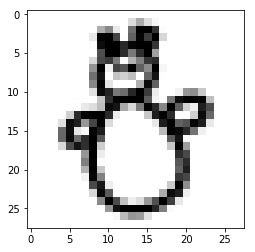

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,10,0,0,...,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,86,97,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58,111,25,0,...,0,42,112,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
import matplotlib.pyplot as plt
import numpy as np

X = bear[750]
X = np.resize(X,(28,28))
X = np.invert(X)
plt.imshow(X, cmap="gray")
plt.show()


df = pd.DataFrame(data=bear)
# df['Type'] = 0
df.head

dt = pd.DataFrame(data=tower)
# dt['Type'] = 1
df.append(dt)


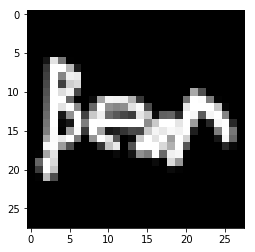

1


In [5]:
from torch.utils.data import Dataset
from torch.utils.data import random_split

import torch

class QuickDrawData(Dataset):
    def __init__(self, tower, bear):
        super(QuickDrawData, self).__init__()
        self.data = np.vstack((tower, bear))
        self.targets = np.concatenate((0*np.ones(tower.shape[0]), 1*np.ones(bear.shape[0])))
        self.classes = ['tower', 'bear']
    
    def __len__(self):
        return self.targets.shape[0]
    
    def __getitem__(self, index):
        return torch.FloatTensor(self.data[index, :].reshape((28, 28))).unsqueeze(0), int(self.targets[index])

quick_draw_data = QuickDrawData(tower, bear)
im, target = quick_draw_data[206408]
plt.imshow(im.squeeze(), cmap='gray')
plt.show()
im.shape
print(target)

In [0]:
train, test = random_split(quick_draw_data, [260000,9563])


In [0]:
# Data set information

image_dims = 1, 28, 28
n_training_samples = len(train) # How many training images to use
n_test_samples = len(test) # How many test images to use
classes = ('bear', 'tower')

# Load the training set
train_set = train
train_sampler = SubsetRandomSampler(
    np.arange(n_training_samples, dtype=np.int64))

#Load the test set
test_set = test
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [8]:
type(test_set)

torch.utils.data.dataset.Subset

In [0]:
class MyCNN(nn.Module):
  
  def __init__(self):
    super(MyCNN, self).__init__()
    
    num_kernels = 16
    
    self.conv1 = nn.Conv2d(1, num_kernels, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    self.maxpool_output_size = int(num_kernels*(image_dims[1]/2) * (image_dims[2]/2))
    
    fcl_size = 64
    self.fc1 = nn.Linear(self.maxpool_output_size, fcl_size)
    self.activation_func = torch.nn.ReLU()
    fc2_size = len(classes)
    self.fc2 = nn.Linear(fcl_size, fc2_size)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.activation_func(x)
    
    x = x.view(-1, self.maxpool_output_size)
    x = self.fc1(x)
    x = self.activation_func(x)
    x = self.fc2(x)
    return x

  def get_loss(self, learning_rate):
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    return loss, optimizer
  

In [0]:
net = MyCNN()

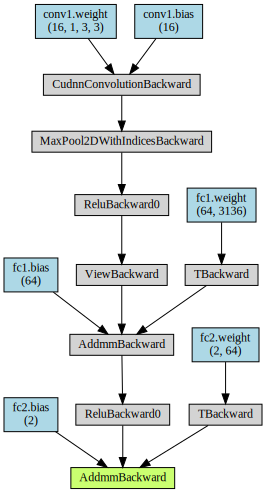

In [11]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1, image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))

# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)
# 
visualize_network(net)

In [0]:
# Define training parameters
batch_size = 32
learning_rate = 1e-2
n_epochs = 10
# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, sampler=train_sampler, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, sampler=test_sampler, num_workers = 2)

def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 20
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):

            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:

            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [13]:
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

Epoch 1, Iteration 20	 train_loss: 33.48 took: 0.19s
Epoch 1, Iteration 40	 train_loss: 1.46 took: 0.13s
Epoch 1, Iteration 60	 train_loss: 1.20 took: 0.13s
Epoch 1, Iteration 80	 train_loss: 0.50 took: 0.13s
Epoch 1, Iteration 100	 train_loss: 0.23 took: 0.13s
Epoch 1, Iteration 120	 train_loss: 0.36 took: 0.13s
Epoch 1, Iteration 140	 train_loss: 0.22 took: 0.13s
Epoch 1, Iteration 160	 train_loss: 0.18 took: 0.12s
Epoch 1, Iteration 180	 train_loss: 0.23 took: 0.12s
Epoch 1, Iteration 200	 train_loss: 0.15 took: 0.13s
Epoch 1, Iteration 220	 train_loss: 0.14 took: 0.12s
Epoch 1, Iteration 240	 train_loss: 0.13 took: 0.12s
Epoch 1, Iteration 260	 train_loss: 0.08 took: 0.13s
Epoch 1, Iteration 280	 train_loss: 0.09 took: 0.12s
Epoch 1, Iteration 300	 train_loss: 0.08 took: 0.12s
Epoch 1, Iteration 320	 train_loss: 0.10 took: 0.12s
Epoch 1, Iteration 340	 train_loss: 0.08 took: 0.13s
Epoch 1, Iteration 360	 train_loss: 0.07 took: 0.13s
Epoch 1, Iteration 380	 train_loss: 0.08 took: 0.

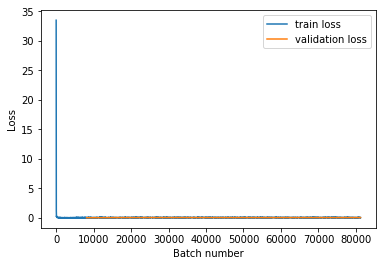

In [14]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

In [15]:
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total
print("Train accuracy is", get_accuracy(net, train_loader))
print("Test accuracy is", get_accuracy(net, test_loader))

Train accuracy is 0.9770884615384615
Test accuracy is 0.9775175154240301


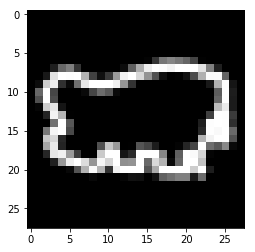

1
1


In [26]:
def examine_label(idx):
    image, label = test_set[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    print(prediction)
    print(label)

examine_label(1)
